# Problem Definition
The company Tetravaal located in Johannesburg manufactures two types of robots, Model $P_{1}$ and Model $P_{2}$. The production plan is consisted of four different sections:  metal machining, plastic moulding, electrical work and assembly. 
The metal machining section has a capacity of 7500 units of $P_{1}$ or 6000 units of $P_{2}$ per month. In other words,  the metal machining process  takes 1/7500 months for $P_{1}$ (ie the theoretical cycle time is 1/7500 months) and 1/6000  month for $P_{2}$. 

Plastic moulding can process 5000 units of $P_{1}$ or 9000 units of $P_{2}$ per month.

Electrical work can process 6000 units of $P_{1}$ or 7000 units of $P_{2}$ per month.

In Assembly, there are two assembly lines that work in parallel, one per each robot model.

The first assembly line can process 4000 units of $P_{1}$ per month

The second assembly line can process 5000 units of $P_{2}$ per month

Knowing that the unitary profit of $P_{1}$ is 500€ and that the unitary profit of $P_{2}$ is 600€, and that both robots have a great demand and therefore all manufactured robots are sold, Michelle Bradley, CEO of Tetravaal, asks his engineering team: 

Calculate the number of units of each robot that needs to be manufactured to maximise profit for the company.

## Model
We want to maximise the company profits:

$\max z = 500x_{1} + 600x_{2}$

where z represents the profits (€). The decision variables are:

$x_{1}:$ units of $P_{1}$ per month
$x_{2}:$ units of $P_{2}$ per month

The objective function is subject to the following constraints:

$x_{1}/7500+x_{2}/6000 \leq 1$ Metal machining constraint

$x_{1}/5000+x_{2}/9000 \leq 1$ Plastic moulding constraint

$x_{1}/6000 + x_{2}/7000 \leq 1$ Electrical work constraint

$x_{1} \leq 4000$ First assembly line constraint  

$x_{2} \leq 5000$ Second assembly line constraint


## Solution using the graphical method
Using Python, we can represent the feasibility region:


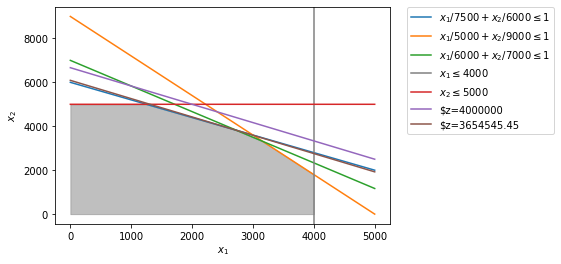

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(0, 5000, 10000)
y1 = (1 - (x/7500))*6000
y2 = (1 -(x/5000))*9000
y3 = (1-(x/6000))*7000
y4 = 5000 + x*0
y5 = 0 + x*0

y9 = (4000000 - 500*x)/600
y10 = (3654545.45 - 500*x)/600

plt.plot(x, y1, label=r'$x_{1}/7500 + x_{2}/6000 \leq 1$')
plt.plot(x, y2, label=r'$x_{1}/5000 + x_{2}/9000 \leq 1$')
plt.plot(x, y3, label=r'$x_{1}/6000 + x_{2}/7000 \leq 1$')
plt.axvline(x=4000, label=r'$x_{1} \leq 4000$', color='grey')
plt.plot(x, y4, label=r'$x_{2} \leq 5000$')
plt.plot(x, y9, label=r'$z=4000000')
plt.plot(x, y10, label=r'$z=3654545.45')

y6 = np.minimum(y4,y1)
y7 = np.minimum(y6,y3)
y8 = np.minimum(y7, y2)

plt.fill_between(x, y8, y5, where=x <= 4000, color='grey', alpha=0.5)
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0. )

### Solution
When we display the objective function, we find out there are two candidates for the solution, one on the limit for $x_{2}$ and the metal machining constraint. We can obtain the value of $x_{1}$ and $x_{2}$ at this point:

$x_{2} = 5000$

$x_{1} = 7500·(1-x_{2}/6000)$



$z = 500·1250+600·5000 = 3006250$

The other point represents the intersection between the metal machining constraint and the electric work constraint:

$(1-x_{1}/7500)*6000 = (1-x_{1}/6000)*7000$

$x_{1} = (7000-6000)/(7/6-6/7.5) = 2727.27$

$x_{2} = 3818.18 $

$z = 500·2727.27+600·3818.18 = 3654545.45$

The second candidate provides a higher value and therefore is the optimal solution

## Solution using PuLP


In [13]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
import pulp

model = pulp.LpProblem("Maximising profits for Tetravaal", pulp.LpMaximize)

variable_names = ['P1', 'P2']

variables = pulp.LpVariable.dicts("Units per month",
                                     (i for i in variable_names),
                                     lowBound=0,
                                     cat='Continuous')

coefficients = [500, 600]

# Objective function
model += (
    pulp.lpSum([
        coefficients[i] * variables[variable_names[i]]
        for i in range(len(variable_names))])
), "Profit"


# And the constraints, the Matrix A
A=[[1/7500, 1/6000], #Coefficients of the first constraint
   [1/5000, 1/9000], #Coefficients of the second constraint
   [1/6000, 1/7000],
   [1/4000, 0], #Coefficients of the second constraint
   [0, 1/5000]] #Coefficients of the third constraint

A = A

# And vector b
b = [1, 1, 1, 1, 1] #limits of the three constraints

constraint_names = ['Metal machining', 'Plastic moulding', 'Electrical work', 'Assembly 1', 'Assembly 2']

# Constraints
for i in range(len(A)):           
    model += pulp.lpSum([
        A[i][j] * variables[variable_names[j]] 
        for j in range(len(variable_names))]) <= b[i] , constraint_names[i]

    # Solve our problem
model.solve(solver=pulp.solvers.GUROBI(msg = 0))
pulp.LpStatus[model.status]


'Optimal'

In [14]:
total_profit = pulp.value(model.objective)
display(Markdown("Total profit is %0.2f €"%total_profit))

display(Markdown("The following table shows the decision variables: "))
var_df = pd.DataFrame.from_dict(variables, orient="index", 
                                columns = ["Variables"])
var_df["Solution (GRB)"] = var_df["Variables"].apply(lambda item: "{:.2f}".format(item.solverVar.X))
var_df["Reduced cost (GRB)"] = var_df["Variables"].apply(lambda item: "{:.2f}".format(item.solverVar.RC))
var_df["Objective Coefficient (GRB)"] = var_df["Variables"].apply(lambda item: "{:.2f}".format(item.solverVar.Obj))
var_df["Objective Lower bound (GRB)"] = var_df["Variables"].apply(lambda item: "{:.2f}".format(item.solverVar.SAObjLow) if item.solverVar.SAObjLow > -0.1 else "-Inf" )
var_df["Objective Upper bound (GRB)"] = var_df["Variables"].apply(lambda item: "{:.2f}".format(item.solverVar.SAObjUp) if item.solverVar.SAObjUp != item.solverVar.UB else "Inf")


display(var_df)


const_dict = dict(model.constraints)
con_df = pd.DataFrame.from_records(list(const_dict.items()), exclude=["Expression"], columns=["Constraint", "Expression"])
con_df["Right Hand Side"]=con_df["Constraint"].apply(lambda item: "{:.2f}".format(const_dict[item].solverConstraint.RHS))
con_df["Slack"]=con_df["Constraint"].apply(lambda item: "{:.2f}".format(const_dict[item].solverConstraint.Slack))
con_df["Shadow Price"]=con_df["Constraint"].apply(lambda item: "{:.2f}".format(const_dict[item].solverConstraint.Pi))
con_df["Min RHS"]=con_df["Constraint"].apply(lambda item: "{:.2f}".format(const_dict[item].solverConstraint.SARHSLow) )
con_df["Max RHS"]=con_df["Constraint"].apply(lambda item: "{:.2f}".format(const_dict[item].solverConstraint.SARHSUp) if const_dict[item].solverConstraint.SARHSUp < 1e10 else "Inf" )


display(Markdown("The following table shows the constraints: "))
display(con_df)

Total profit is 3654545.45 €

The following table shows the decision variables: 

Variables Solution (GRB) Reduced cost (GRB)  \
P1  Units_per_month_P1        2727.27               0.00   
P2  Units_per_month_P2        3818.18               0.00   

   Objective Coefficient (GRB) Objective Lower bound (GRB)  \
P1                      500.00                      480.00   
P2                      600.00                      428.57   

   Objective Upper bound (GRB)  
P1                      700.00  
P2                      625.00

The following table shows the constraints: 

Constraint Right Hand Side Slack Shadow Price Min RHS Max RHS
0   Metal_machining            1.00  0.00   3272727.27    0.97    1.06
1  Plastic_moulding            1.00  0.03         0.00    0.97     Inf
2   Electrical_work            1.00  0.00    381818.18    0.92    1.01
3        Assembly_1            1.00  0.32         0.00    0.68     Inf
4        Assembly_2            1.00  0.24         0.00    0.76     Inf